# Classification

## Import Modules

In [11]:
import pickle
import os

# data processing
import pandas as pd
from pandas import DataFrame
import numpy as np
from scipy import stats
import encoding_tools
import matplotlib.pyplot as plt

# training and testing
from sklearn import svm, metrics, model_selection
from gpmodel import gpmodel, gpkernel, chimera_tools
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.utils.fixes import loguniform
from sklearn.pipeline import make_pipeline, make_union
from sklearn.tree import DecisionTreeClassifier

## Import & Process Data

In [12]:
activations = pd.read_csv('../data/activations.csv', index_col=0)


with open('../data/EFI_ID_List.p', 'rb') as EFI:
    EFIs = pd.Series(map(str, pickle.load(EFI)))
    
with open('../data/metabolite_dict.p', 'rb') as metabolite:
    metabolite_dict = pickle.load(metabolite)
renaming_dict = dict(zip(range(len(metabolite_dict)), metabolite_dict.values()))

with open('../data/Protein_seq_dict.p', 'rb') as Protein_seq:
    Protein_seq_dict = pickle.load(Protein_seq)
    

def load_seq(msa=False):
    """
    Load the sequence data. Run before fitting and testing.
    
    Parameters:
        msa (bool): Use MSA aligned sequences (default False)
    """
    Protein_seq_dict = {}
    if msa:
        from Bio import SeqIO
        with open("../data/sequences_muscle.fas") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                Protein_seq_dict[int(record.id)] = str(record.seq.lower())
    else:
        with open('../data/Protein_seq_dict.p', 'rb') as Protein_seq:
            Protein_seq_dict = pickle.load(Protein_seq)
    

def select_X_and_Y(df, x_rows, y_column):
    """
    Select the given X rows and Y column
    """
    # filter out empty columns
    not_dropped = ~pd.isnull(df[y_column])
    not_dropped = pd.Series(not_dropped, index=df.index)
    Ys = df[not_dropped].loc[x_rows, y_column]
    return x_rows, Ys


def process_data(df, threshold=0, transpose=False, renaming=None):
    """
    Convert numerical absorbance data into categorical data
    (active=1, inactive=-1)
    """
    formatted = df > threshold
    if renaming:
        formatted = formatted.rename(renaming)
    if transpose:
        return formatted.transpose() * 2 - 1
    return formatted * 2 - 1


def prepare_train_test(metabolite_name, threshold=0, reshape=True):
    """
    Format the data and return the training set and testing set.
    """
    df = process_data(activations, threshold=threshold, transpose=True, renaming=renaming_dict)
    xs, ys = select_X_and_Y(df, EFIs, metabolite_name)
    
    max_len = len(max(Protein_seq_dict.values(), key=len))
    fillchar = '-' # This is whats used in the GP-UCB paper
    Padded_dict = {}
    OH_dict = {}
    for ID in EFIs:
        Padded_dict[ID] = Protein_seq_dict[int(ID)].upper().ljust(max_len, fillchar)
        OH_dict[ID] = encoding_tools.one_hot_seq(seq_input=Padded_dict[ID])

    mapped_xs = xs.map(OH_dict)
    
    if reshape:
        for i, x in enumerate(mapped_xs):
            mapped_xs[i] = x.reshape(len(x)*21)
        
    X = list(mapped_xs)
    y = ys

    return train_test_split(X, y, test_size=0.2)

## Trained Pipelines
The following pipelines are trained using TPOT with default parameters. Each pipeline corresponds to a specific metabolite.

In [13]:
from stacking_estimator import StackingEstimator
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.kernel_approximation import RBFSampler
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBClassifier
from copy import copy

pipelines = {
    'ATP': make_pipeline(
        StackingEstimator(estimator=DecisionTreeClassifier(criterion="gini", max_depth=6, 
                                                           min_samples_leaf=13, min_samples_split=5, random_state=42)),
        DecisionTreeClassifier(criterion="entropy", max_depth=2, min_samples_leaf=5, min_samples_split=15, random_state=42)
    ),
    'Blank': make_pipeline(
        StackingEstimator(estimator=DecisionTreeClassifier(criterion="gini", max_depth=9, min_samples_leaf=10,
                                                           min_samples_split=5, random_state=42)),
        SGDClassifier(alpha=0.001, eta0=1.0, fit_intercept=False, l1_ratio=0.5, learning_rate="invscaling",
                      loss="log", penalty="elasticnet", power_t=0.1, random_state=42)
    ),
    'D-erythronate-4-phosphate': make_pipeline(
        RFE(estimator=ExtraTreesClassifier(criterion="entropy", max_features=1.0, 
                                           n_estimators=100, random_state=42), step=0.4),
        MultinomialNB(alpha=0.1, fit_prior=True)
    ),
    'D-threonate-4-phosphate': make_pipeline(
        RBFSampler(gamma=0.5),
        XGBClassifier(learning_rate=0.001, max_depth=2, min_child_weight=2, n_estimators=100,
                      n_jobs=1, subsample=0.8500000000000001, random_state=42, verbosity=0)
    ),
    'Glycerol-2-phospate': make_pipeline(
        StackingEstimator(estimator=GaussianNB()),
        MLPClassifier(alpha=0.01, learning_rate_init=0.001, random_state=42)
    ),
    'Glycerol-3-phosphate': make_pipeline(
        make_union(
            StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
                                                                   max_features=0.1, min_samples_leaf=15,
                                                                   min_samples_split=14, n_estimators=100,
                                                                   random_state=42, subsample=0.9000000000000001)),
            FunctionTransformer(copy)
        ),
        GaussianNB()
    ),
    'L-erythronate-4-phosphate': make_pipeline(
        StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.5, max_depth=8,
                                                               max_features=0.6000000000000001, min_samples_leaf=2,
                                                               min_samples_split=17, n_estimators=100,
                                                               random_state=42, subsample=0.45)),
        GaussianNB()
    ),
    'phosphoenolpyruvate': make_pipeline(
        RFE(estimator=ExtraTreesClassifier(criterion="entropy", max_features=0.6000000000000001,
                                           n_estimators=100, random_state=42), step=0.7000000000000001),
        KNeighborsClassifier(n_neighbors=3, p=1, weights="distance")
    ),
    'Pyrophosphate': make_pipeline(
        RBFSampler(gamma=0.6000000000000001),
        MLPClassifier(alpha=0.1, learning_rate_init=0.01, random_state=42)
    ),
    'TTP': XGBClassifier(learning_rate=0.01, max_depth=9,
                         min_child_weight=13, n_estimators=100,
                         n_jobs=1, subsample=1.0, 
                         random_state=42, verbosity=0)
}


def set_param_recursive(pipeline_steps, parameter, value):
    """Recursively iterate through all objects in the pipeline and set a given parameter.
    Parameters
    ----------
    pipeline_steps: array-like
        List of (str, obj) tuples from a scikit-learn pipeline or related object
    parameter: str
        The parameter to assign a value for in each pipeline object
    value: any
        The value to assign the parameter to in each pipeline object
    Returns
    -------
    None
    """
    for (_, obj) in pipeline_steps:
        recursive_attrs = ["steps", "transformer_list", "estimators"]
        for attr in recursive_attrs:
            if hasattr(obj, attr):
                set_param_recursive(getattr(obj, attr), parameter, value)
        if hasattr(obj, "estimator"):  # nested estimator
            est = getattr(obj, "estimator")
            if hasattr(est, parameter):
                setattr(est, parameter, value)
        if hasattr(obj, parameter):
            setattr(obj, parameter, value)

In [21]:
def train_test(metabolite_name, threshold=0):
    """
    Run the optimized classifier for the specific metabolite and report the metrics.
    """
    X_train, X_test, y_train, y_test = prepare_train_test(metabolite_name, threshold=threshold)
    clf = pipelines[metabolite_name]
    set_param_recursive(clf.steps, 'random_state', 42)
    clf.fit(X_train, y_train)
    result = clf.predict(X_test)
    
    print('Metabolite: {}'.format(metabolite_name))
    print('Optimal classifier: {}'.format(clf.steps))
    print('Confusion matrix:'.format(metabolite_name))
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()

Metabolite: Blank
Optimal classifier: [('stackingestimator', StackingEstimator(estimator=DecisionTreeClassifier(max_depth=9,
                                                   min_samples_leaf=10,
                                                   min_samples_split=5,
                                                   random_state=42))), ('sgdclassifier', SGDClassifier(alpha=0.001, eta0=1.0, fit_intercept=False, l1_ratio=0.5,
              learning_rate='invscaling', loss='log', penalty='elasticnet',
              power_t=0.1, random_state=42))]
Confusion matrix:


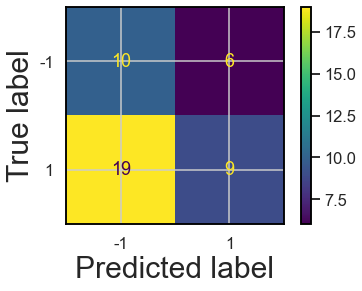


Metabolite: phosphoenolpyruvate
Optimal classifier: [('rfe', RFE(estimator=ExtraTreesClassifier(criterion='entropy',
                                   max_features=0.6000000000000001,
                                   random_state=42),
    step=0.7000000000000001)), ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))]
Confusion matrix:


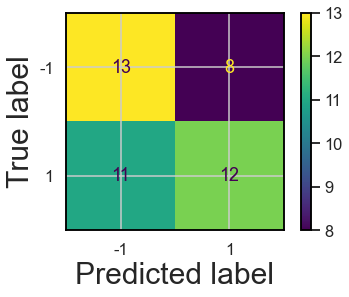


Metabolite: Glycerol-2-phospate
Optimal classifier: [('stackingestimator', StackingEstimator(estimator=GaussianNB())), ('mlpclassifier', MLPClassifier(alpha=0.01, random_state=42))]
Confusion matrix:


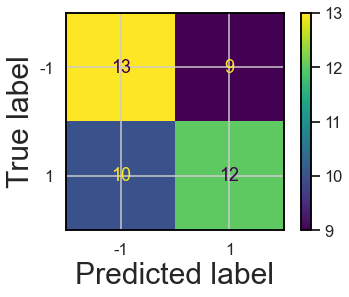


Metabolite: Glycerol-3-phosphate
Optimal classifier: [('featureunion', FeatureUnion(transformer_list=[('stackingestimator',
                                StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=1.0,
                                                                                       max_depth=4,
                                                                                       max_features=0.1,
                                                                                       min_samples_leaf=15,
                                                                                       min_samples_split=14,
                                                                                       random_state=42,
                                                                                       subsample=0.9000000000000001))),
                               ('functiontransformer',
                                FunctionTransformer(func=<function c

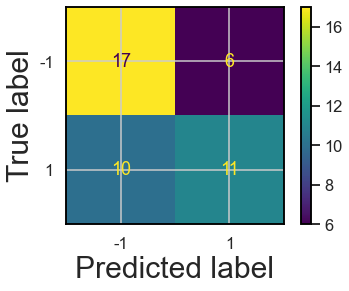


Metabolite: D-erythronate-4-phosphate
Optimal classifier: [('rfe', RFE(estimator=ExtraTreesClassifier(criterion='entropy', max_features=1.0,
                                   random_state=42),
    step=0.4)), ('multinomialnb', MultinomialNB(alpha=0.1))]
Confusion matrix:


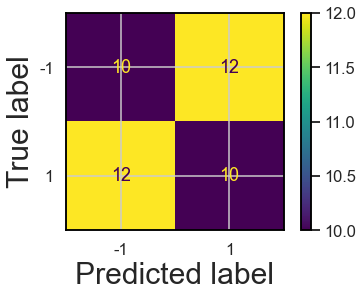

In [33]:
load_seq(msa=False)

for i, metabolite in enumerate(list(metabolite_dict.values())[:5]):
    med = activations.transpose()[i].median()
    train_test(metabolite, threshold=med)
    print()

## Using MSA Aligned Data

In [8]:
from stacking_estimator import StackingEstimator
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.kernel_approximation import RBFSampler
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBClassifier
from copy import copy


msa_pipelines = {
    'ATP': XGBClassifier(learning_rate=0.1, max_depth=4,
                         min_child_weight=13, n_estimators=100,
                         n_jobs=1, subsample=0.9500000000000001,
                         verbosity=0),
    'Blank': make_pipeline(
        StackingEstimator(estimator=MLPClassifier(alpha=0.0001, learning_rate_init=0.001)),
        GaussianNB()
    ),
    'D-erythronate-4-phosphate': make_pipeline(
        StackingEstimator(estimator=SGDClassifier(alpha=0.01, eta0=0.01,
                                                  fit_intercept=False, l1_ratio=0.5,
                                                  learning_rate="invscaling", loss="perceptron",
                                                  penalty="elasticnet", power_t=0.1)),
        StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=True, criterion="gini",
                                                         max_features=0.7000000000000001, min_samples_leaf=20,
                                                         min_samples_split=4, n_estimators=100)),
        StackingEstimator(estimator=KNeighborsClassifier(n_neighbors=12, p=1, weights="distance")),
        StackingEstimator(estimator=LogisticRegression(C=0.1, dual=False, penalty="l2")),
        BernoulliNB(alpha=1.0, fit_prior=False)
    ),
    'D-threonate-4-phosphate': XGBClassifier(learning_rate=0.01, max_depth=10,
                                             min_child_weight=2, n_estimators=100,
                                             n_jobs=1, subsample=1.0, verbosity=0),
    'Glycerol-2-phospate': DecisionTreeClassifier(criterion="entropy", max_depth=3,
                                                  min_samples_leaf=5, min_samples_split=9),
    'Glycerol-3-phosphate': make_pipeline(
        StackingEstimator(estimator=MLPClassifier(alpha=0.1, learning_rate_init=0.001)),
        StackingEstimator(estimator=XGBClassifier(learning_rate=0.1, max_depth=7,
                                                  min_child_weight=16, n_estimators=100,
                                                  n_jobs=1, subsample=0.55, verbosity=0)),
        LinearSVC(C=5.0, dual=True, loss="squared_hinge", penalty="l2", tol=0.1)
    ),
    'L-erythronate-4-phosphate': make_pipeline(
        make_union(
            FunctionTransformer(copy),
            FunctionTransformer(copy)
        ),
        VarianceThreshold(threshold=0.0001),
        BernoulliNB(alpha=1.0, fit_prior=False)
    ),
    'phosphoenolpyruvate': ExtraTreesClassifier(bootstrap=True, criterion="entropy",
                                                max_features=0.25, min_samples_leaf=2,
                                                min_samples_split=9, n_estimators=100),
    'Pyrophosphate': ExtraTreesClassifier(bootstrap=False, criterion="gini",
                                          max_features=0.35000000000000003, min_samples_leaf=18,
                                          min_samples_split=9, n_estimators=100),
    'TTP': make_pipeline(
        StackingEstimator(estimator=MultinomialNB(alpha=10.0, fit_prior=False)),
        XGBClassifier(learning_rate=0.01, max_depth=9,
                      min_child_weight=4, n_estimators=100,
                      n_jobs=1, subsample=0.45, verbosity=0)
    )
}

def set_param_recursive(pipeline_steps, parameter, value):
    """Recursively iterate through all objects in the pipeline and set a given parameter.
    Parameters
    ----------
    pipeline_steps: array-like
        List of (str, obj) tuples from a scikit-learn pipeline or related object
    parameter: str
        The parameter to assign a value for in each pipeline object
    value: any
        The value to assign the parameter to in each pipeline object
    Returns
    -------
    None
    """
    for (_, obj) in pipeline_steps:
        recursive_attrs = ["steps", "transformer_list", "estimators"]
        for attr in recursive_attrs:
            if hasattr(obj, attr):
                set_param_recursive(getattr(obj, attr), parameter, value)
        if hasattr(obj, "estimator"):  # nested estimator
            est = getattr(obj, "estimator")
            if hasattr(est, parameter):
                setattr(est, parameter, value)
        if hasattr(obj, parameter):
            setattr(obj, parameter, value)

In [9]:
def train_test_msa(metabolite_name, threshold=0):
    """
    Run the optimized classifier for the specific metabolite and report the metrics.
    """
    X_train, X_test, y_train, y_test = prepare_train_test(metabolite_name, threshold=threshold)
    clf = msa_pipelines[metabolite_name]
    set_param_recursive(clf.steps, 'random_state', 42)
    clf.fit(X_train, y_train)
    result = clf.predict(X_test)
    
    print('Metabolite: {}'.format(metabolite_name))
    print('Optimal classifier: {}'.format(clf.steps))
    print('Confusion matrix:'.format(metabolite_name))
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()

Metabolite: Blank
Optimal classifier: [('stackingestimator', StackingEstimator(estimator=DecisionTreeClassifier(max_depth=9,
                                                   min_samples_leaf=10,
                                                   min_samples_split=5,
                                                   random_state=42))), ('sgdclassifier', SGDClassifier(alpha=0.001, eta0=1.0, fit_intercept=False, l1_ratio=0.5,
              learning_rate='invscaling', loss='log', penalty='elasticnet',
              power_t=0.1, random_state=42))]
Confusion matrix:


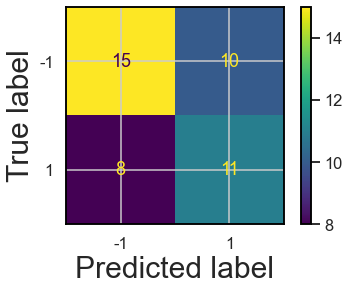


Metabolite: phosphoenolpyruvate
Optimal classifier: [('rfe', RFE(estimator=ExtraTreesClassifier(criterion='entropy',
                                   max_features=0.6000000000000001,
                                   random_state=42),
    step=0.7000000000000001)), ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))]
Confusion matrix:


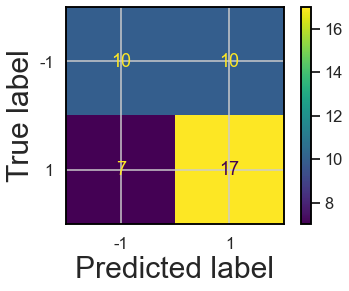


Metabolite: Glycerol-2-phospate
Optimal classifier: [('stackingestimator', StackingEstimator(estimator=GaussianNB())), ('mlpclassifier', MLPClassifier(alpha=0.01, random_state=42))]
Confusion matrix:


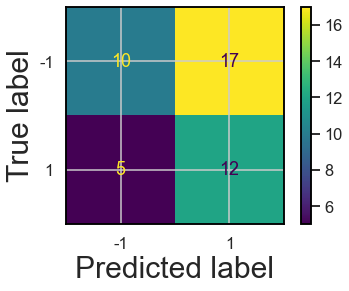


Metabolite: Glycerol-3-phosphate
Optimal classifier: [('featureunion', FeatureUnion(transformer_list=[('stackingestimator',
                                StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=1.0,
                                                                                       max_depth=4,
                                                                                       max_features=0.1,
                                                                                       min_samples_leaf=15,
                                                                                       min_samples_split=14,
                                                                                       random_state=42,
                                                                                       subsample=0.9000000000000001))),
                               ('functiontransformer',
                                FunctionTransformer(func=<function c

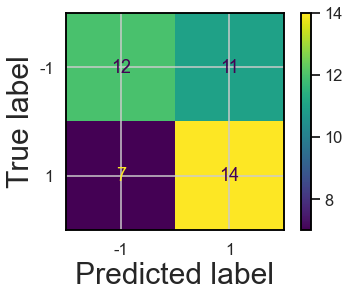


Metabolite: D-erythronate-4-phosphate
Optimal classifier: [('rfe', RFE(estimator=ExtraTreesClassifier(criterion='entropy', max_features=1.0,
                                   random_state=42),
    step=0.4)), ('multinomialnb', MultinomialNB(alpha=0.1))]
Confusion matrix:


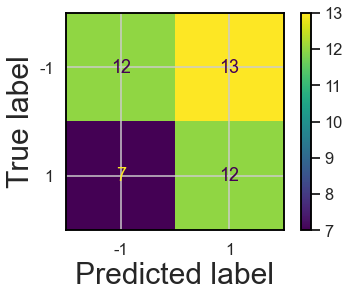

In [16]:
load_seq(msa=True)

for i, metabolite in enumerate(list(metabolite_dict.values())[:5]):
    med = activations.transpose()[i].median()
    train_test_msa(metabolite, threshold=med)
    print()